In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
import math
import itertools
import datetime
#from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib

# Read endogenous and exogenous data and filter country/dates

In [2]:
# We read the endogenous data (coronavirus data)

covid_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
covid = pd.read_csv(covid_url, parse_dates=['date'], index_col=['date'])

In [3]:
# We filter the country, dates and the variable to predict

country = 'France'
variable = 'new_cases'
initialdate = '01-01-2020'
enddate = '31-07-2020' 

# Filtering country and dates
covid_ctry = covid[covid['location']==country]
covid_ctry = covid_ctry.loc[initialdate:enddate]

# Making the data a daily series and applying 7-day rolling mean
covid_ctry_var = covid_ctry[variable]
#covid_ctry_var = covid_ctry_var.resample('D').sum()
covid_ctry_varR = covid_ctry_var.rolling(7).mean().dropna()

In [4]:
# We now read the exogenous data (for now, from a local file)

exogenous = pd.read_csv('./data/exogenas.csv', parse_dates=[0], index_col=[0])

In [5]:
# We now need to filter the country/dates, and aply 7-day rolling mean:

exogenous_ctry = exogenous.loc[:, exogenous.columns.str.contains(country)]
exogenous_ctry = exogenous_ctry.loc[initialdate:enddate]

# We apply the 7-day rolling mean, as in the endogenous data
exogenous_ctryR = exogenous_ctry.rolling(7).mean().dropna()

In [6]:
# We check that the only NaNs removed are the 6 positions created by the 7-rolling mean
print(len(covid_ctry_varR) == len(covid_ctry_var) - 6)
print(len(exogenous_ctryR) == len(exogenous_ctry) - 6)

True
True


# Visualize endogenous and exogenous data and normalize it all

(207,) (207, 13)


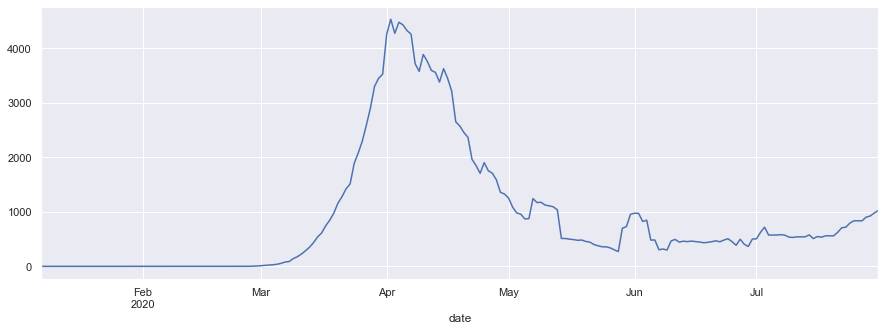

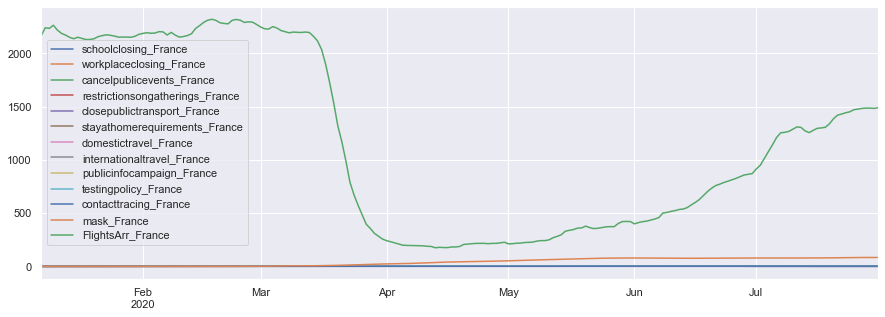

In [8]:
print(covid_ctry_varR.shape, exogenous_ctryR.shape)
covid_ctry_varR.plot()
exogenous_ctryR.plot()

In [9]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(exogenous_ctryR)
scaled_input = pd.DataFrame(scaled_input, index=exogenous_ctryR.index, columns=exogenous_ctryR.columns)
X = scaled_input

In [10]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR.values.reshape(-1,1))
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.name)
y = scaled_output.resample('1D').sum()

(207,) (207, 13)


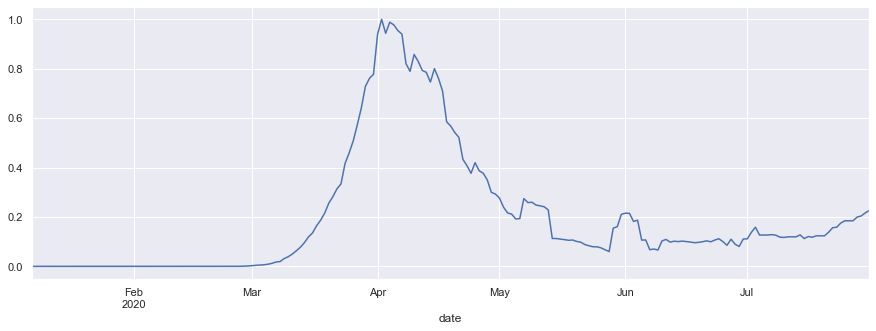

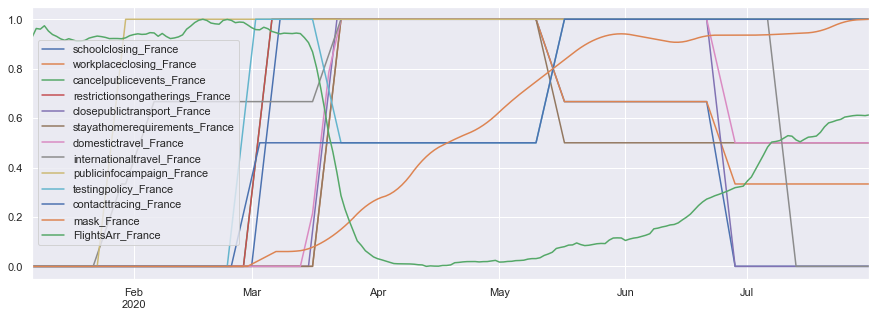

In [11]:
print(y.shape, X.shape)
y.plot()
X.plot()

# Split endogenous and exogenous data into train/test

In [12]:
# We are going to use 85% for training, since most of the series is the big curve, 
# and then we have the smaller changes in coronavirus cases towards the end
train_size = int(len(covid_ctry_varR) * 0.85)
test_size = len(covid_ctry_varR) - train_size
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [13]:
train_size, test_size

(175, 32)

# Stationarity: estimate differencing term (d)

In [14]:
# Performing different tests to estimate best value of 'd'

## Adf Test
d_adf = ndiffs(y_train, test='adf')
print('ADF test: ', d_adf)

# KPSS test
d_kpss = ndiffs(y_train, test='kpss')
print('KPSS test: ', d_kpss)

# PP test:
d_pp = ndiffs(y_train, test='pp')
print('PP test: ', d_pp)

ADF test:  2
KPSS test:  1
PP test:  1


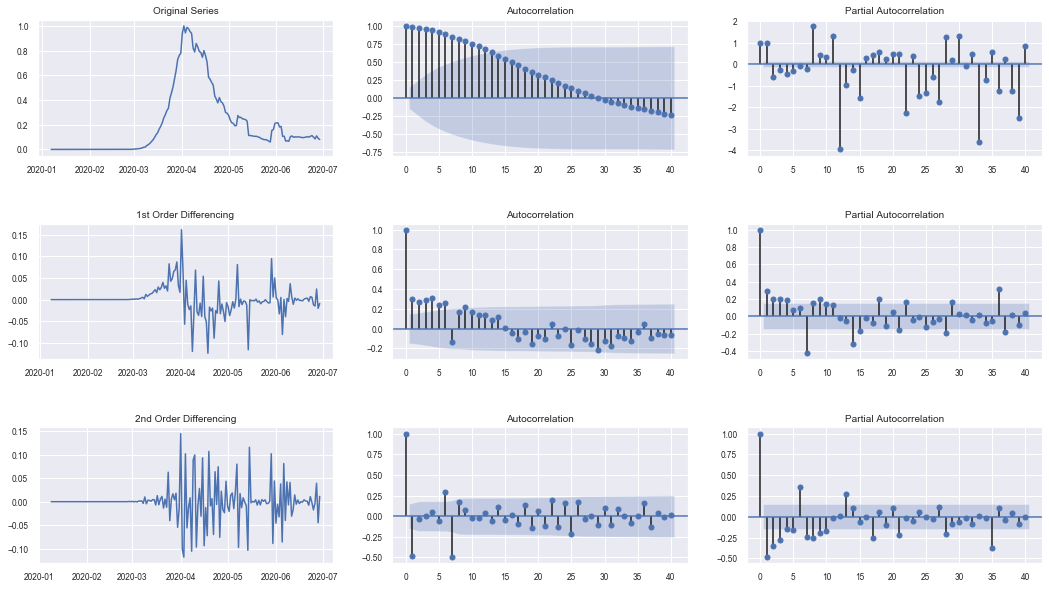

In [15]:
# Plotting ACF and PACF with the different 'd' values from previous step

plt.rcParams.update({'figure.figsize':(18,10), 'figure.subplot.hspace':0.5,
                     'xtick.labelsize':'x-small', 'ytick.labelsize':'x-small', 'axes.titlesize':'small'})
fig, axes = plt.subplots(3, 3)

# Original Series
axes[0, 0].plot(y_train); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(y_train, lags=40, ax=axes[0, 1])
sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=axes[0, 2])

# 1st Differencing
axes[1, 0].plot(y_train.diff()); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().dropna(), lags=40, ax=axes[1, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().dropna(), lags=40, ax=axes[1, 2])

# 2nd Differencing
axes[2, 0].plot(y_train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 1])
sm.graphics.tsa.plot_pacf(y_train.diff().diff().dropna(), lags=40, ax=axes[2, 2])
plt.show()
sns.reset_defaults
plt.rcParams["figure.figsize"] = (15, 5)

**Consider if d=1 would be best, since the ACF/PACF for d=2 turns largely negative at lag 1, which is an indication that the series may be over-differenced**

In [16]:
def test_stationarity(timeseries):

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=3).mean()
    rolling_std = timeseries.rolling(window=3).std()

    # Plot rolling statistics

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Result of Dicky=Fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

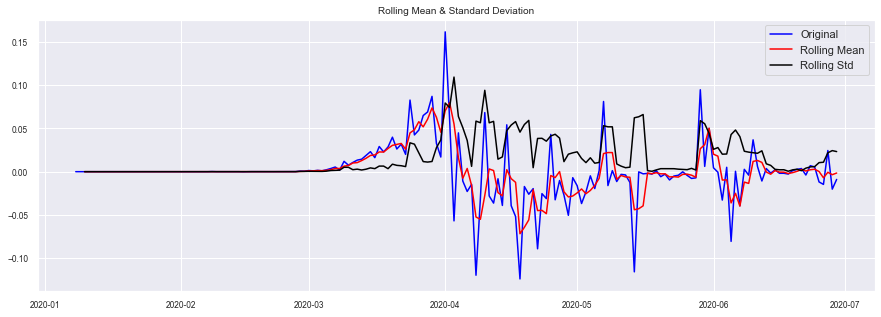

Result of Dicky=Fuller Test
Test Statistic           -3.018664
p-value                   0.033188
#Lags Used               14.000000
#Observations Used      159.000000
Critical Value (1%)      -3.472161
Critical Value (5%)      -2.879895
Critical Value (10%)     -2.576557
dtype: float64


In [19]:
test_stationarity(y_train.diff().dropna())

# Estimate order p and q of ARIMA model, using auto_arima

Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=-681.646, BIC=-628.041, Time=0.689 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=-607.861, BIC=-560.562, Time=0.100 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=-650.820, BIC=-600.368, Time=0.515 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=-683.893, BIC=-633.440, Time=0.537 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=-609.861, BIC=-565.715, Time=0.468 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=-681.894, BIC=-628.288, Time=0.563 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=-678.914, BIC=-622.154, Time=0.665 seconds
Total fit time: 3.538 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 357.946
Date:                Sat, 15 Aug 2020   AIC  

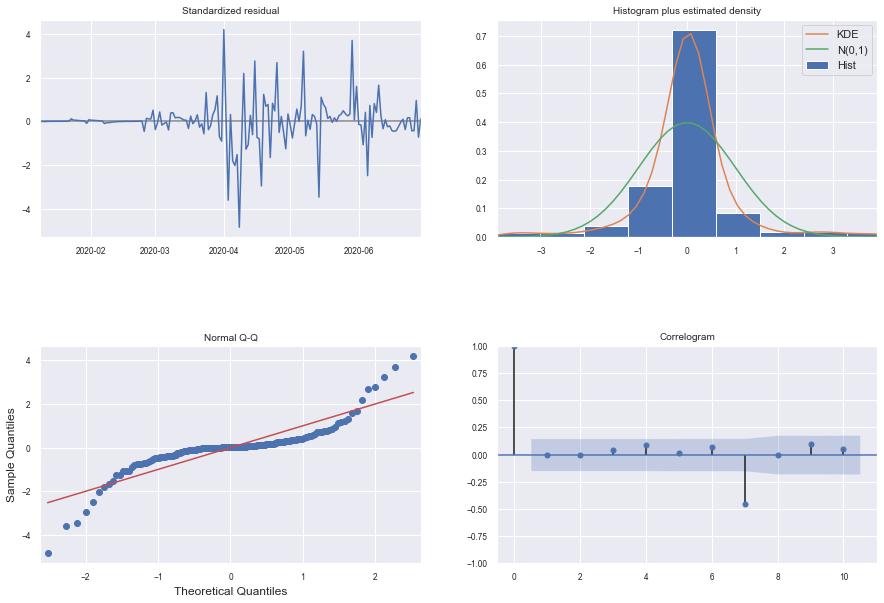

In [23]:
modelauto7 = pm.auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                    #  test='adf',       # use kpss to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                    #  m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                    # seasonal=False,   # No Seasonality
                    #  start_P=0, 
                    #  D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(modelauto7.summary())
modelauto7.plot_diagnostics(figsize=(15,10))
plt.show()

# Train and fit SARIMAX model with previous selected (p,d,q) orders

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  175
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 377.901
Date:                Sat, 15 Aug 2020   AIC                           -719.802
Time:                        01:32:53   BIC                           -662.939
Sample:                    01-07-2020   HQIC                          -696.735
                         - 06-29-2020                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_France               -0.0369      0.463     -0.080      0.936      -0.943       0.870
workplaceclosing_France            -0.2713      1.442     -0.188    

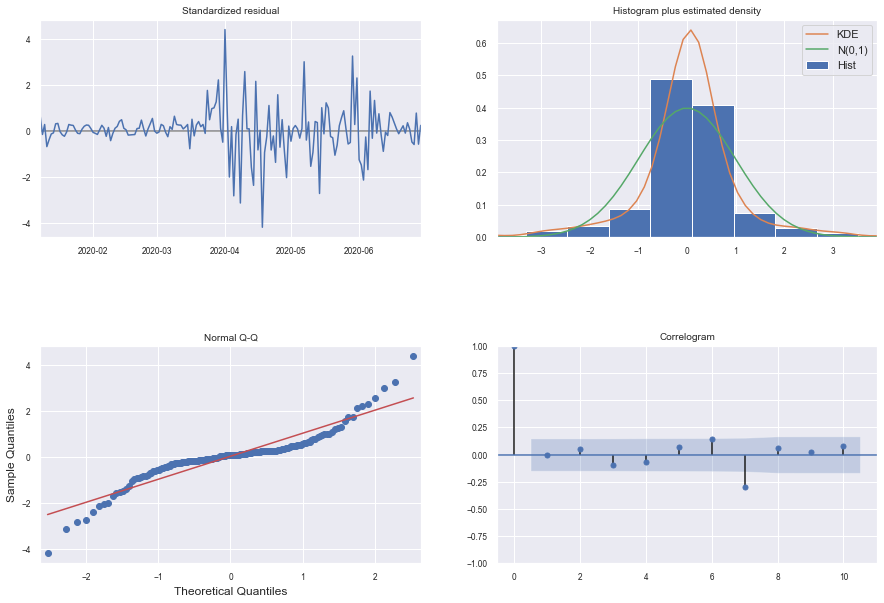

In [24]:
model1 = sm.tsa.statespace.SARIMAX(y_train, order=(0,1,4), exog=X_train)
results1 = model1.fit()
print(results1.summary())
results1.plot_diagnostics(figsize=(15,10));

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  175
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 367.194
Date:                Sat, 15 Aug 2020   AIC                           -702.389
Time:                        01:33:10   BIC                           -651.844
Sample:                    01-07-2020   HQIC                          -681.884
                         - 06-29-2020                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_France                0.0254      0.680      0.037      0.970      -1.307       1.358
workplaceclosing_France            -0.2190      2.241     -0.098    

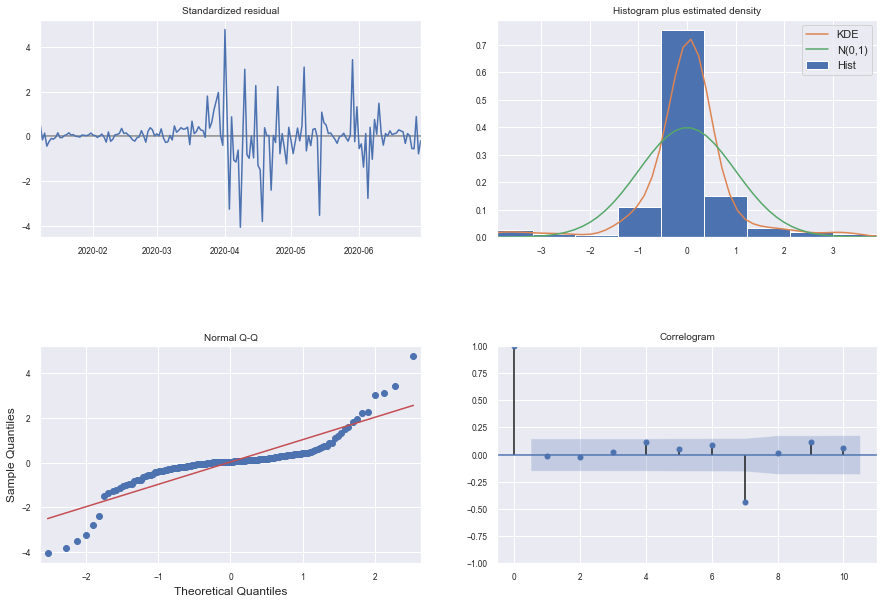

In [25]:
model2 = sm.tsa.statespace.SARIMAX(y_train, order=(1,1,1), exog=X_train)
results2 = model2.fit()
print(results2.summary())
results2.plot_diagnostics(figsize=(15,10));

# Perform/plot in-sample prediction and out-of-sample forecast and evaluate model RMSE

In [25]:
train_size, test_size, X_test.shape

(158, 18, (18, 13))

In [30]:
# Select best model
results_best = results2

In [31]:
# Generate in-sample predictions (train) and evaluate RMSE:

in_predictions = results_best.predict(exog=X_train)

print("Train RMSE: %.3f" % np.sqrt(mean_squared_error(y_train, in_predictions)))

Train RMSE: 0.044


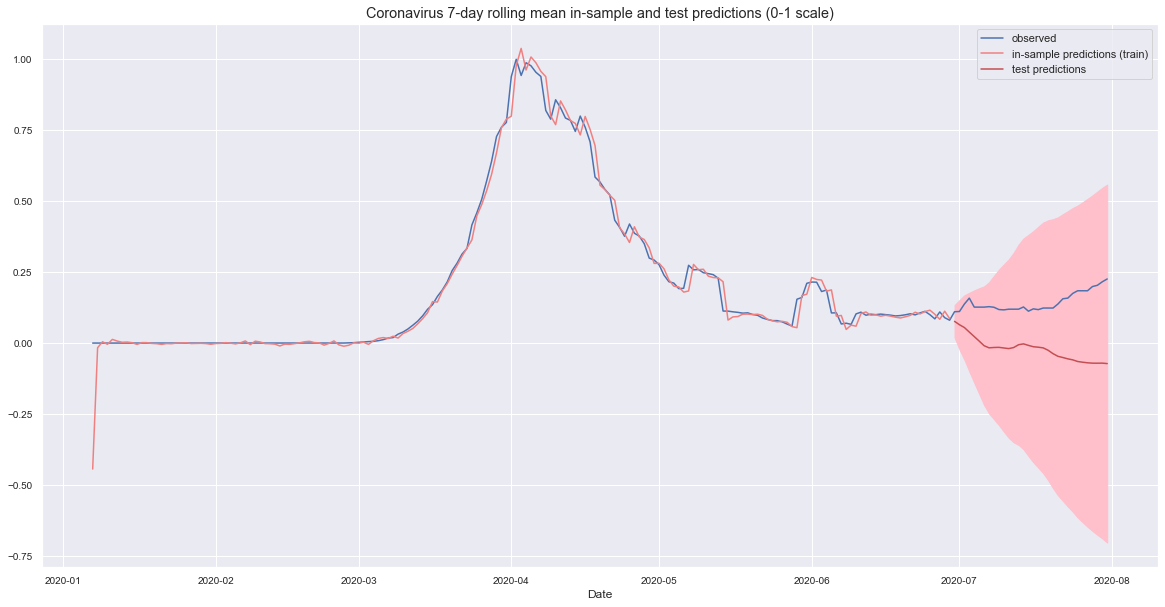

In [32]:
# Generate forecast for the test sample, updating our model by simulating days passing with our test set:

#def forecast_one_step(i):
#    forecast = results2.get_forecast(steps=1, exog=X_test.iloc[i].values.reshape(1,-1))
#    fc = forecast.predicted_mean
#    conf_int = forecast.conf_int()
#    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

#forecasts = []
#confidence_intervals = []
#i = 0

#for new_ob in y_test:
#    fc, conf = forecast_one_step(i)
#    forecasts.append(fc)
#    confidence_intervals.append(conf)

    # Update the existing model
#    results2.append(new_ob, exog=X_test.iloc[i].values.reshape(1,-1))
#    i = i+1


# Generate forecast for the test sample
#one_step_forecast = results2.get_prediction(start=train_size, end=train_size+test_size-1, exog=X_test)
one_step_forecast = results_best.get_forecast(steps=test_size, exog=X_test)


# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
#print(mean_predict.values)

# plot the data
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'figure.figsize':(20,10), 'xtick.labelsize':'small', 'ytick.labelsize':'small', 'axes.titlesize':'large'})
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train)
plt.plot(in_predictions.index, in_predictions, color='lightcoral', label= 'in-sample predictions (train)')

# plot mean predictions (test)
plt.plot(mean_forecast.index, mean_forecast, color='r', label='test predictions')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (0-1 scale)')
plt.legend()
plt.show()

In [33]:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(y[train_size:], mean_forecast.values)))

Test RMSE: 0.179


# Scale data back to original values

In [34]:
trainPredict = sc_out.inverse_transform(in_predictions.values.reshape(-1,1))
trainPredictS = pd.Series(trainPredict.flatten(), index=covid_ctry_varR[:train_size].index, name=covid_ctry_varR.name)

In [35]:
testPredict = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
testPredictS = pd.Series(testPredict.flatten(), index=covid_ctry_varR[train_size:].index, name=covid_ctry_varR.name)

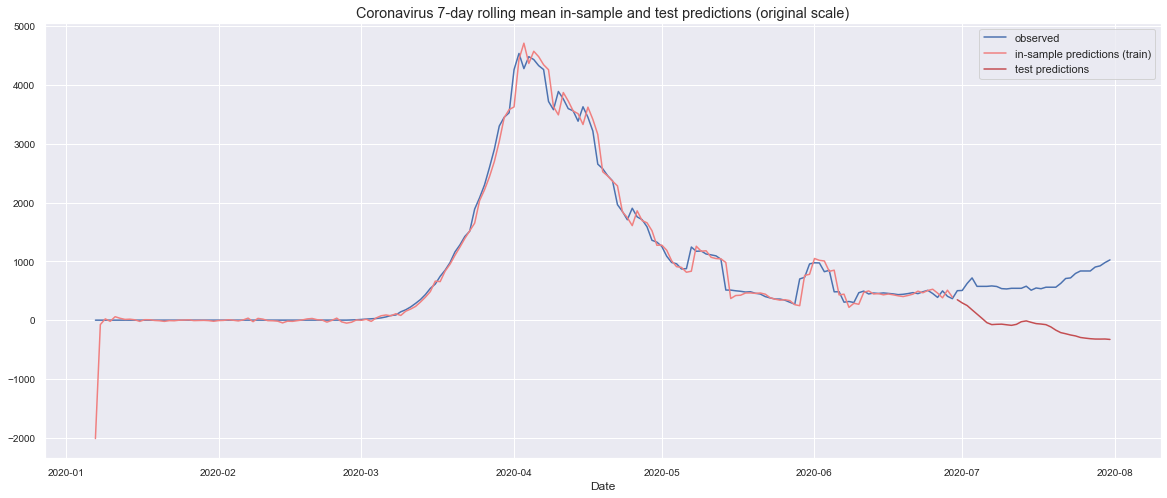

In [36]:
# plot the data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(covid_ctry_varR.index, covid_ctry_varR, label='observed')

# plot your mean predictions
plt.plot(trainPredictS.index, trainPredictS, color='lightcoral', label='in-sample predictions (train)')

plt.plot(testPredictS.index, testPredictS, color='r', label='test predictions')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample and test predictions (original scale)')
plt.rcParams["figure.figsize"] = (20, 8)
plt.legend()
plt.show()

In [37]:
print("Test RMSE (original scale): %.3f" % np.sqrt(mean_squared_error(covid_ctry_varR[train_size:], testPredictS)))

Test RMSE (original scale): 809.897


# Save model so we can then update with future values

In [28]:
%pwd

'C:\\Users\\marta\\Documents\\MasterDataScience\\project\\KSchool-Master-Final-Project'

In [39]:
# Set model name
filename = './models/FranceSARIMAXmodel.pkl'

# Pickle it
joblib.dump(results_best, filename)

['./models/FranceSARIMAXmodel.pkl']

In [40]:
# Load the model back in
loaded_model = joblib.load(filename)

# Update the model
#loaded_model.update(__dfnew___)

In [41]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              new_cases   No. Observations:                  175
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 367.194
Date:                Sat, 15 Aug 2020   AIC                           -702.389
Time:                        01:37:28   BIC                           -651.844
Sample:                    01-07-2020   HQIC                          -681.884
                         - 06-29-2020                                         
Covariance Type:                  opg                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_France                0.0254      0.680      0.037      0.970      -1.307       1.358
workplaceclosing_France            -0.2190      2.241     -0.098      0.922      -4.611       4.173
cancelpublicevents_France           0.0094      0.538      0.018      0.986      -1.045       1.064
restrictionsongatherings_France     0.0094      0.538      0.018      0.986      -1.045       1.064
closepublictransport_France         0.0492      0.606      0.081      0.935      -1.139       1.237
stayathomerequirements_France       0.0725      1.649      0.044      0.965      -3.160       3.305
domestictravel_France              -0.0487      0.713     -0.068      0.946      -1.446       1.349
internationaltravel_France         -0.0237      2.345     -0.010      0.992      -4.620       4.573
publicinfocampaign_France          -0.0063      1.975     -0.003      0.997      -3.877       3.864
testingpolicy_France                0.0344      0.543      0.063      0.949      -1.029       1.098
contacttracing_France              -0.2194      0.963     -0.228      0.820      -2.106       1.667
mask_France                        -0.2577      0.541     -0.477      0.634      -1.318       0.802
FlightsArr_France                  -0.4782      0.415     -1.153      0.249      -1.291       0.335
ar.L1                               0.8825      0.068     12.947      0.000       0.749       1.016
ma.L1                              -0.7368      0.110     -6.710      0.000      -0.952      -0.522
sigma2                              0.0009   4.64e-05     18.457      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       79.41   Jarque-Bera (JB):               382.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              30.72   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.76e+16. Standard errors may be unstable.
"""

# Update model with test observations, to get it ready for future forecasts

In [42]:
# Update model with test sample and re-fit parameters:
res_updated = results_best.append(y_test, exog=X_test, refit=True)

C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\marta\miniconda3\envs\kschool\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  207
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 448.914
Date:                Sat, 15 Aug 2020   AIC                           -865.829
Time:                        01:37:38   BIC                           -812.583
Sample:                    01-07-2020   HQIC                          -844.294
                         - 07-31-2020                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
schoolclosing_France                0.0324      0.482      0.067      0.946      -0.912       0.977
workplaceclosing_France            -0.1776      1.881     -0.094    

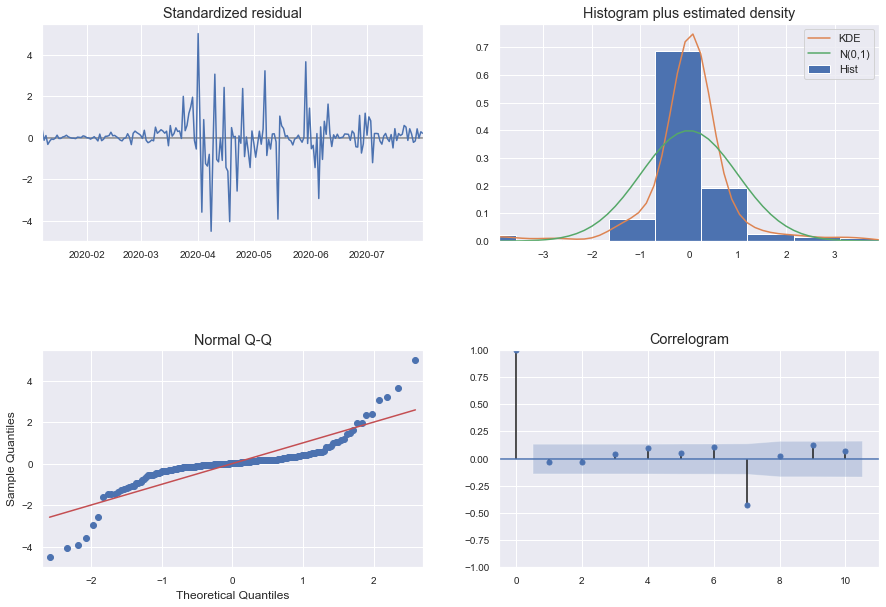

In [43]:
# Print summary of updated model and plot diagnostics, to confirm everything working as expected:
print(res_updated.summary())
res_updated.plot_diagnostics(figsize=(15,10));

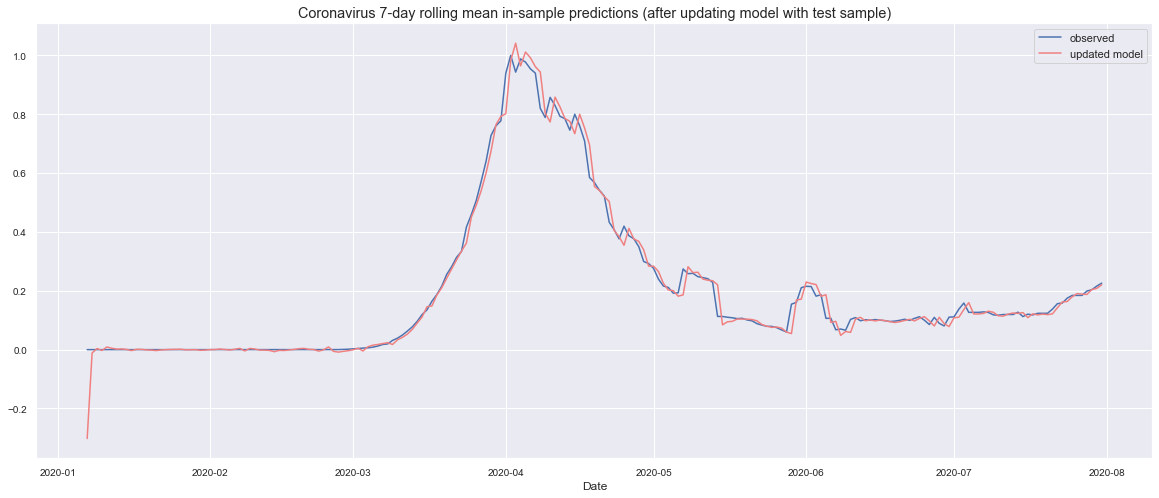

In [44]:
# Plot the updated data
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(y.index, y, label='observed')

# plot in-sample predictions (train+test)
plt.plot(res_updated.fittedvalues.index, res_updated.fittedvalues, color='lightcoral', label= 'updated model')
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean in-sample predictions (after updating model with test sample)')
plt.legend()
plt.show()

In [45]:
# Save model again, after updating it with test sample:
#filename = './SpainSARIMAXmodel2.pkl'

# Pickle it
joblib.dump(res_updated, filename)

['./models/FranceSARIMAXmodel.pkl']

# Perform forecast

In [46]:
exog_forecast = exogenous.loc['2020-07-25':'2020-08-07', exogenous.columns.str.contains(country)]
exog_forecast.loc[:, exog_forecast.columns.str.contains('Flights')] = \
                   exog_forecast.loc[:, exog_forecast.columns.str.contains('Flights')]\
                  .shift(7, fill_value=exog_forecast.loc['2020-07-25':'2020-07-31', exog_forecast.columns.str.contains('Flights')])
exog_forecast = exog_forecast.iloc[1:, :]

exog_forecastR = exog_forecast.rolling(7).mean().dropna()
exog_forecastR

,schoolclosing_France,workplaceclosing_France,cancelpublicevents_France,restrictionsongatherings_France,closepublictransport_France,stayathomerequirements_France,domestictravel_France,internationaltravel_France,publicinfocampaign_France,testingpolicy_France,contacttracing_France,mask_France,FlightsArr_France
2020-08-01,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,83.4375,1488.857143
2020-08-02,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,83.5000,1488.857143
2020-08-03,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,83.5625,1488.857143
2020-08-04,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,83.6250,1488.857143
2020-08-05,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,83.6875,1488.857143
2020-08-06,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,83.7500,1488.857143
2020-08-07,0.0,1.0,2.0,4.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,83.8125,1488.857143


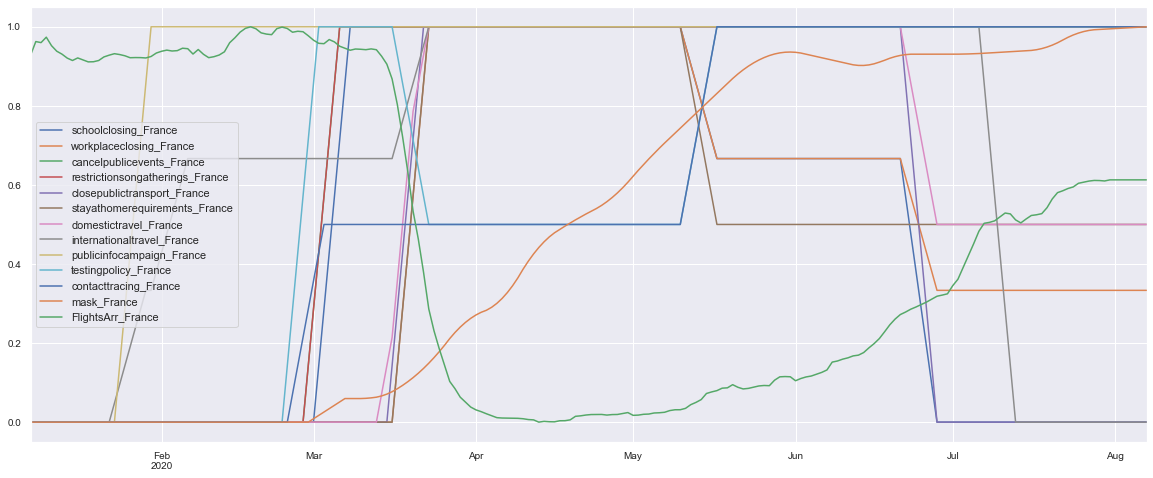

In [47]:
exog_conc = pd.concat([exogenous_ctryR, exog_forecastR])
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_conc)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_conc.index, columns=exog_conc.columns)
X_fc = scaled_input_fc
X_fc.plot()

[0.23033939 0.23520761 0.23952391 0.24335294 0.24675177 0.24977079
 0.25245451]


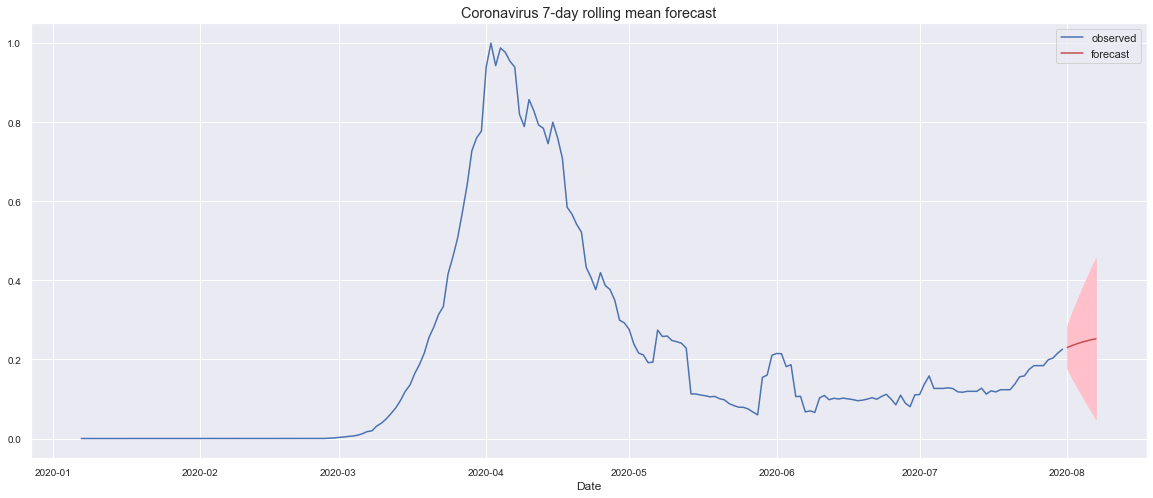

In [48]:
# Generate out of sample forecast
forecast = res_updated.get_forecast(steps=7, exog=X_fc['2020-08-01':'2020-08-07'])

# Extract prediction mean
mean_forecast = forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower new_cases']
upper_limits = confidence_intervals.loc[:,'upper new_cases']

# Print best estimate  predictions
print(mean_forecast.values)

# plot the data
plt.plot(y.index, y, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.title('Coronavirus 7-day rolling mean forecast')
plt.legend()
plt.show()